## **MYO7A**


In [1]:
import re
import subprocess
from io import StringIO
from collections.abc import Iterator
import requests
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import Entrez, SeqIO, SearchIO, AlignIO, Phylo
from Bio.Blast import NCBIWWW
from pymsaviz import MsaViz

# Entrez.email = "hannu@hanhi.fi"
# NCBIWWW.email = "hannu@hanhi.fi"


GENE = "MYO7A"
UNIPROT_ID = "Q13402"
SPECIES = [
    "Homo sapiens",
    "Cebus imitator",
    "Mus musculus",
    "Heterocephalus glaber",
    "Myotis brandtii",
    "Elephas maximus",
    "Coturnix japonica",
    "Chrysemys picta",
    "Nothobranchius furzeri",
    "Amphiprion ocellaris",
    "Lytechinus variegatus",
]


def get_orgn(description: str):
    species_re = "(" + "|".join(SPECIES) + ")"
    return re.search(species_re, description).group(0)


# Helper for finding dictionaries by key and optionally value from nested JSON data
def find_records(container: dict | list, key: str, val: str = "") -> Iterator[dict]:
    if isinstance(container, dict):
        for k, v in container.items():
            if k == key and (val == "" or v == val):
                yield container
            elif isinstance(v, (dict, list)):
                yield from find_records(v, key, val)
    elif isinstance(container, list):
        for e in container:
            if isinstance(e, (dict, list)):
                yield from find_records(e, key, val)

### 1. UniProt


In [9]:
UNIPROT_URL = "https://rest.uniprot.org/uniprotkb/"

payload = {
    "format": "json",
    "fields": "protein_name,protein_families,length,cc_alternative_products,ft_domain,ft_mod_res,cc_function,cc_disease",
}
response = requests.get(UNIPROT_URL + UNIPROT_ID, params=payload)
data = response.json()

protein_name = next(find_records(data, "fullName"))["fullName"]["value"]
protein_families = next(find_records(data, "commentType", "SIMILARITY"))["texts"][0][
    "value"
]
length = str(data["sequence"]["length"]) + " aa"
cc_alternative_products = len(
    next(find_records(data, "commentType", "ALTERNATIVE PRODUCTS"))["isoforms"]
)
ft_domain = ", ".join(
    [obj["description"] for obj in find_records(data, "type", "Domain")]
)
ft_mod_res = ", ".join(
    [obj["description"] for obj in find_records(data, "type", "Modified residue")]
)
cc_function = next(find_records(data, "commentType", "FUNCTION"))["texts"][0]["value"]
cc_disease = [obj["diseaseId"] for obj in find_records(data, "diseaseId")]

j = 21
print("Protein name:".rjust(j), protein_name)
print("Protein families:".rjust(j), protein_families)
print("Length:".rjust(j), length)
print("Isoforms:".rjust(j), cc_alternative_products)
print("Domains:".rjust(j), ft_domain)
print("Modified residues:".rjust(j), ft_mod_res)
print("Function:".rjust(j), cc_function)
print("Diseases:".rjust(j), ("\n" + " " * (j + 1)).join(cc_disease))

        Protein name: Unconventional myosin-VIIa
    Protein families: Belongs to the TRAFAC class myosin-kinesin ATPase superfamily. Myosin family
              Length: 2215 aa
            Isoforms: 8
             Domains: Myosin motor, IQ 1, IQ 2, IQ 3, IQ 4, IQ 5, MyTH4 1, FERM 1, SH3, MyTH4 2, FERM 2
   Modified residues: Phosphoserine, Phosphothreonine
            Function: Myosins are actin-based motor molecules with ATPase activity. Unconventional myosins serve in intracellular movements. Their highly divergent tails bind to membranous compartments, which are then moved relative to actin filaments. In the retina, plays an important role in the renewal of the outer photoreceptor disks. Plays an important role in the distribution and migration of retinal pigment epithelial (RPE) melanosomes and phagosomes, and in the regulation of opsin transport in retinal photoreceptors. In the inner ear, plays an important role in differentiation, morphogenesis and organization of cochlear hair

### 2. QuickGO

- Search for all annotations that match UniProt ID of the gene
- Read the results into a dataframe and remove duplicates


In [3]:
QUICKGO_ANNOTATION_URL = "https://www.ebi.ac.uk/QuickGO/services/annotation/search"

page = 1
results = []
while True:
    payload = {
        "geneProductId": UNIPROT_ID,
        "includeFields": "goName",
        "limit": 200,
        "page": page,
    }
    response = requests.get(QUICKGO_ANNOTATION_URL, params=payload)
    data = response.json()
    results.extend(data["results"])

    if page == data["pageInfo"]["total"]:
        break
    page += 1

terms = pd.DataFrame(results, columns=["goId", "goName", "goAspect"])
terms.drop_duplicates(subset=["goId"], inplace=True, ignore_index=True)
terms

,goId,goName,goAspect
0,GO:0007605,sensory perception of sound,biological_process
1,GO:0042490,mechanoreceptor differentiation,biological_process
2,GO:0000146,microfilament motor activity,molecular_function
3,GO:0000166,nucleotide binding,molecular_function
4,GO:0003774,cytoskeletal motor activity,molecular_function
5,GO:0003779,actin binding,molecular_function
6,GO:0005515,protein binding,molecular_function
7,GO:0005516,calmodulin binding,molecular_function
8,GO:0005524,ATP binding,molecular_function
9,GO:0019904,protein domain specific binding,molecular_function


#### GO ancestor graph

- Sample five GO-terms from the results and fetch their ancestor graph (.png)


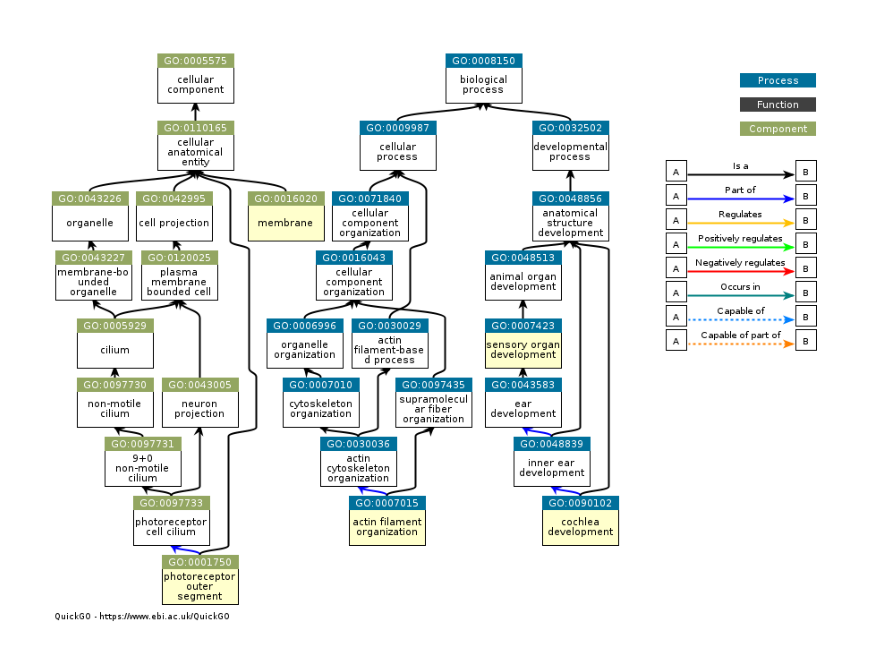

In [6]:
QUICKGO_CHART_URL = (
    "https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{ids}/chart"
)

n = 5
sample_ids = ",".join(terms["goId"].sample(n=n, random_state=11).to_list())

payload = {"ids": sample_ids}
response = requests.get(QUICKGO_CHART_URL, payload)

chart_bytes = np.asarray(bytearray(response.content))
chart_bgr = cv.imdecode(chart_bytes, cv.IMREAD_COLOR)
chart = cv.cvtColor(chart_bgr, cv.COLOR_BGR2RGB)
# cv.imwrite("gochart.png", chart_bgr)

fig = plt.figure(figsize=[10, 10])
plt.axis("off")
plt.imshow(chart)

### 3. Entrez

- Query for mRNA sequences of the gene in the database RefSeq
- Fetch longest result into `SeqRecord` object


In [2]:
handle = Entrez.esearch(
    db="nuccore",
    term=f'("Homo sapiens"[Orgn] AND {GENE}[Gene] AND biomol_mrna[PROP] AND srcdb_refseq[PROP]) NOT "PREDICTED"[Title]',
    sort="sequence length",
)
results = Entrez.read(handle)

handle = Entrez.efetch(db="nuccore", id=results["IdList"][0], rettype="fasta")
mrna = SeqIO.read(handle, "fasta")

### 4. BLAST

- Search for similar sequences in select organisms with suite **blastn** from database **Reference RNA sequences**
- Pick top scoring hit for each organism into `top_result_df`. E value and Identity given for best HSP.


In [10]:
organisms = " OR ".join([f'"{s}"[Orgn]' for s in SPECIES[1:]])
handle = NCBIWWW.qblast(
    "blastn",
    "refseq_rna",
    mrna.id,
    entrez_query=organisms,
    hitlist_size=100,
)
blast_result = SearchIO.read(handle, "blast-xml")

top_result = {}
for hit in blast_result:
    try:
        organism = get_orgn(hit.description)
        if organism not in top_result:
            top_result[organism] = hit
    except:
        pass

# Latex table creation
# for tx, hit in top_result.items():
#     print("\\textit{"+tx+"}", hit.accession.replace("_","\\_"), str(hit.seq_len)+" \\\\", sep=" & ")

top_result_df = pd.DataFrame([{"Description": hit.description, "#HSP": len(hit), "E value": hit[0].evalue, "Ident": hit[0].ident_num/hit[0].aln_span, "Acc. Len": hit.seq_len, "Accession": hit.accession} for hit in top_result.values()])
with pd.option_context('display.max_colwidth', None):
    display(top_result_df.sort_values("Ident", ascending=False))

,Description,#HSP,E value,Ident,Acc. Len,Accession
3,"PREDICTED: Cebus imitator myosin VIIA (MYO7A), transcript variant X2, mRNA",2,0.0,0.952489,7372,XM_017533058
4,"PREDICTED: Heterocephalus glaber myosin VIIA (Myo7a), mRNA",2,0.0,0.911796,7318,XM_013067417
0,"PREDICTED: Elephas maximus indicus myosin VIIA (MYO7A), transcript variant X2, mRNA",1,0.0,0.911618,9948,XM_049889740
1,"PREDICTED: Myotis brandtii myosin VIIA (MYO7A), transcript variant X4, mRNA",2,0.0,0.908360,9541,XM_014540388
2,"Mus musculus myosin VIIA (Myo7a), transcript variant 1, mRNA",3,0.0,0.891658,7481,NM_001256081
5,"PREDICTED: Coturnix japonica myosin VIIA (MYO7A), transcript variant X6, mRNA",2,0.0,0.803626,7484,XM_015852500
7,"PREDICTED: Chrysemys picta bellii myosin VIIA (MYO7A), mRNA",3,0.0,0.800145,8349,XM_042849556
6,"PREDICTED: Amphiprion ocellaris myosin VIIAa (myo7aa), transcript variant X4, mRNA",3,0.0,0.787118,7688,XM_055012531
8,"PREDICTED: Nothobranchius furzeri unconventional myosin-VIIa (LOC107396139), transcript variant X2, mRNA",2,0.0,0.762340,12445,XM_054734303
9,"PREDICTED: Lytechinus variegatus myosin-VIIa-like (LOC121429434), transcript variant X2, mRNA",3,0.0,0.687371,7119,XM_041626427


- Fetch sequences of top results


In [11]:
handle = Entrez.efetch(db="nuccore", id=",".join(top_result_df["Accession"].to_list()), rettype="fasta")
mrna_homologs = list(SeqIO.parse(handle, "fasta"))
mrna_all = [mrna, *mrna_homologs]

### 5. Multiple sequence alignment

- Construct MSA using the L-INS-i method of `mafft`


In [12]:
mrna_all_fasta = "".join([rec.format("fasta") for rec in mrna_all])
output = subprocess.run(
    ["linsi","--preservecase","--thread","4","/dev/stdin"], input=mrna_all_fasta, capture_output=True, text=True
)
msa_fasta = output.stdout
msa = AlignIO.read(StringIO(msa_fasta), "fasta")

for rec in msa:
    rec.id = get_orgn(rec.description).replace(' ','_')

- Visual inspection of MSA


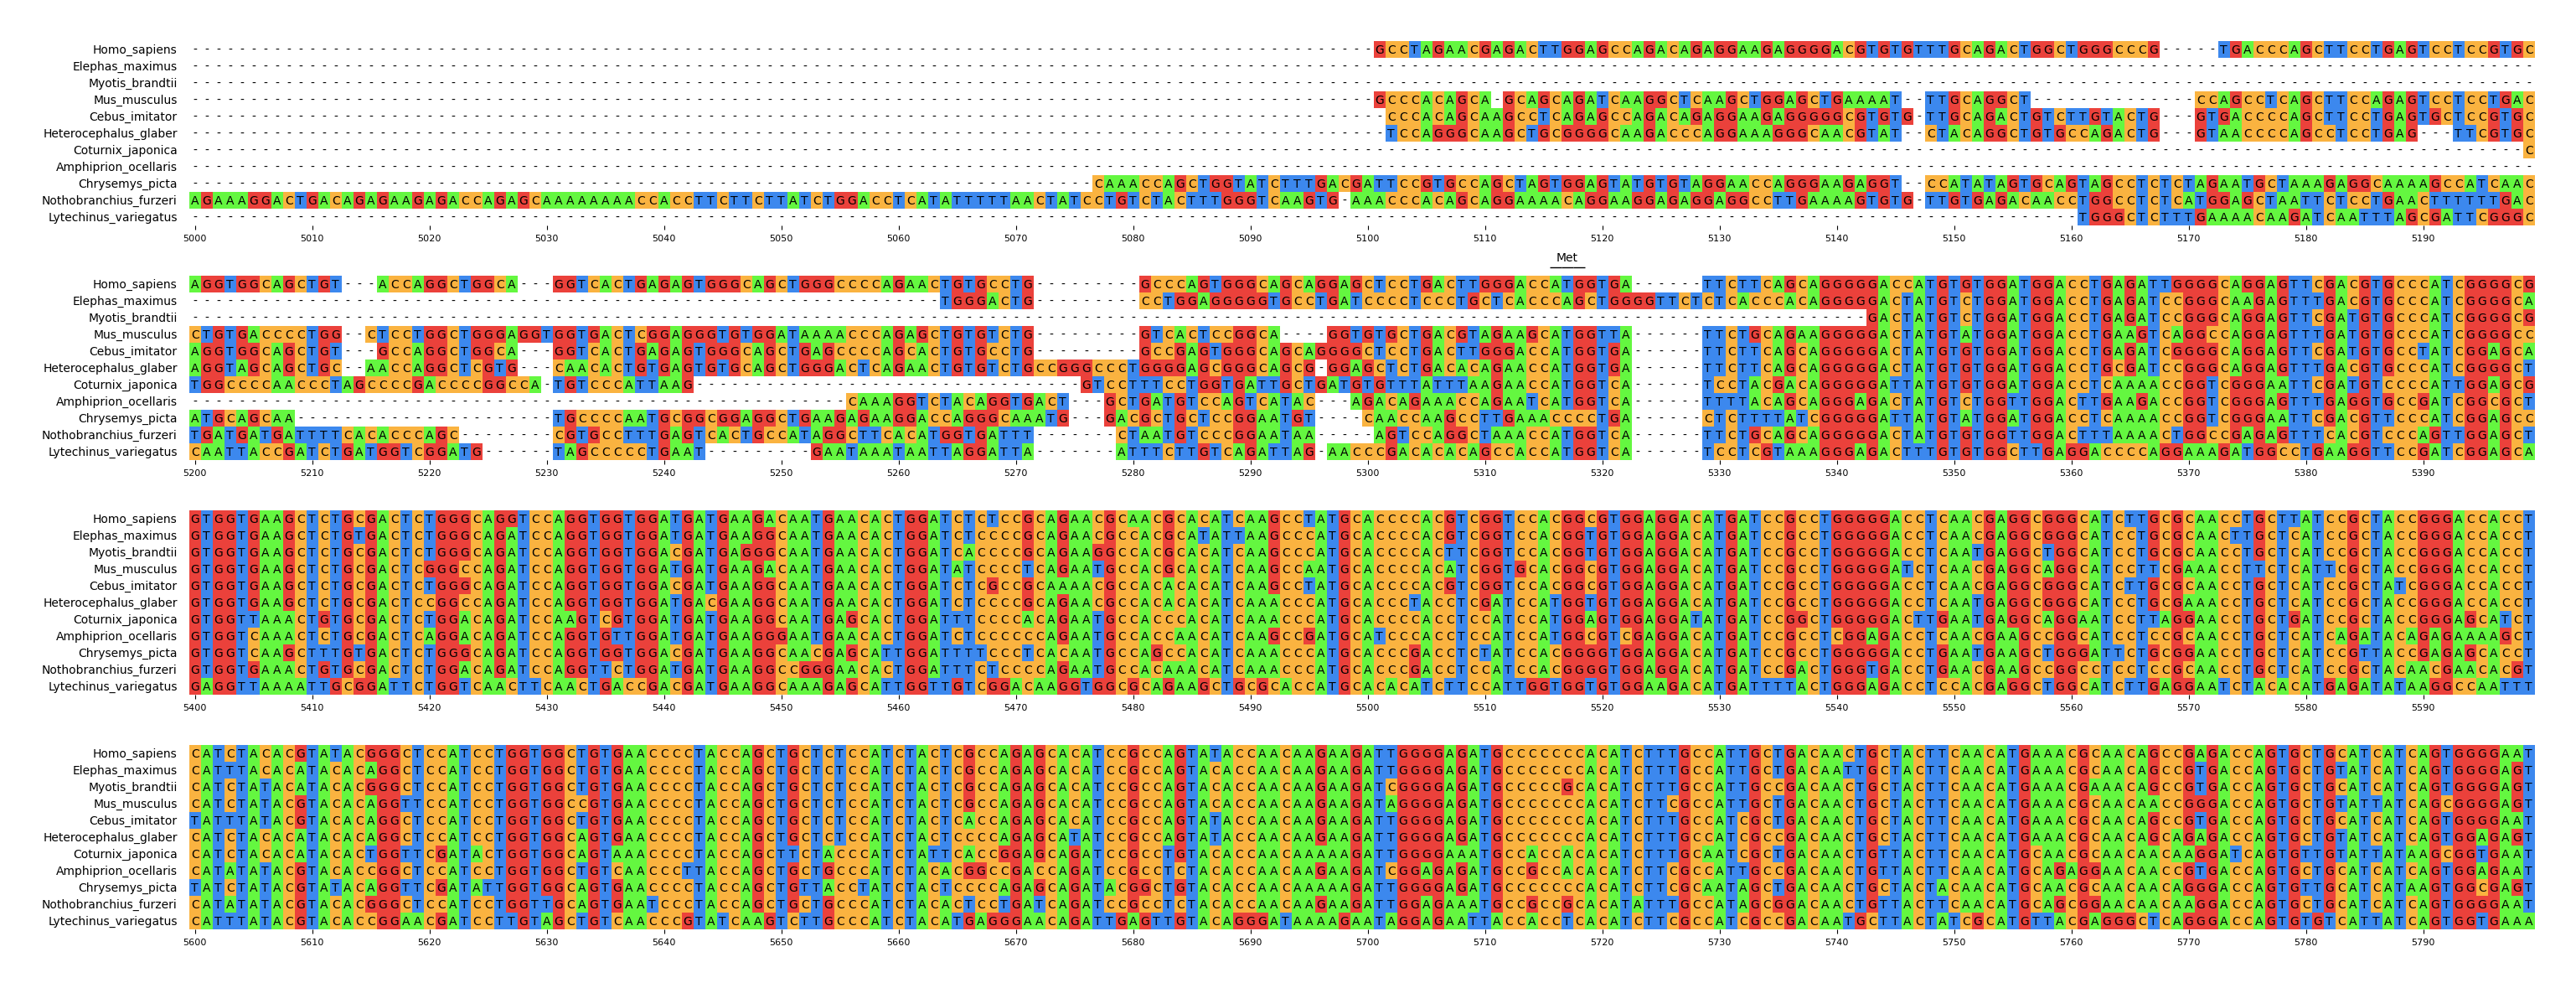

In [16]:
mv = MsaViz(msa, start=5000, end=5799, wrap_length=200)
mv.add_text_annotation((5316,5318), "Met")
#mv.savefig("msa.png")
fig = mv.plotfig()

### 6. Phylogenetic tree inference


- Construct phylogenetic tree using **IQ-TREE** with the following options:
  - _(Default)_ Determine the best substitution model (under BIC) with _ModelFinder Plus_
  - Estimate branch support values with 1000 bootstrap replicas
  - Select _L. variegatus_ (green sea urchin) as the outgroup


In [ ]:
AlignIO.write(msa, "iqtree_temp.fasta", "fasta")
subprocess.run(
    [
        "iqtree",
        "-s",
        "iqtree_temp.fasta",
        "-T",
        "AUTO",
        "--prefix",
        "./iqtree_temp",
        "-B",
        "1000",
        "-o",
        "Lytechinus_variegatus",
    ]
);
tree = Phylo.read("iqtree_temp.treefile", "newick")

- Plot tree


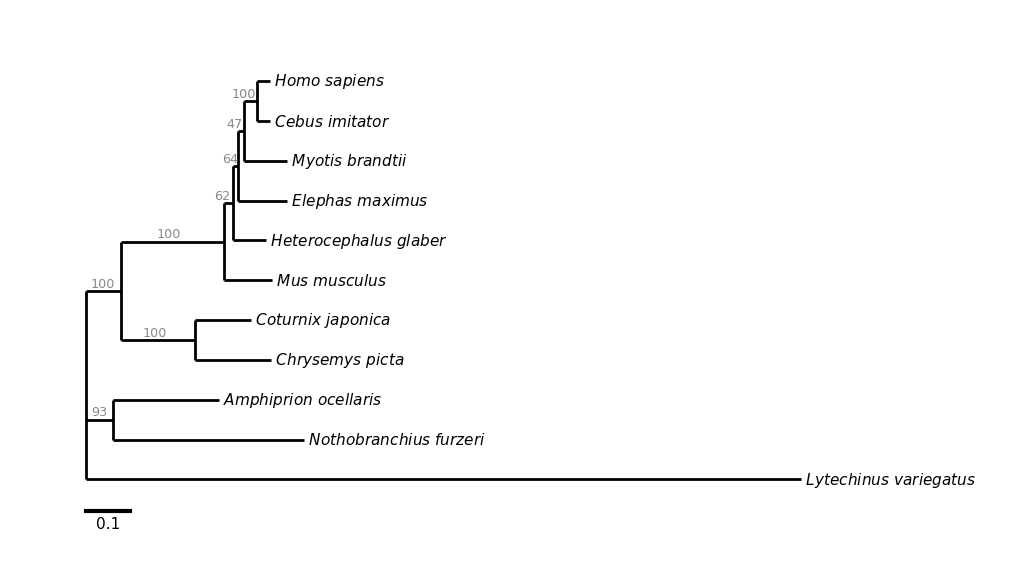

In [19]:
labelf = lambda x: "$\it{" + str(x).replace('_','\ ') + "}$" if str(x) != "Clade" else str(x)

plt.rc('font',size=11)
plt.rc('lines',linewidth=2)
fig, ax = plt.subplots(figsize=(12,6))
ax.spines[["left","right","top"]].set_visible(False)
ax.spines.bottom.set(bounds=[0,0.1], linewidth=3)
ax.set_xticks([0.05],[0.1],minor=True)
ax.tick_params(length=0, which="minor")
Phylo.draw(tree, axes=ax, do_show=False, label_func=labelf, xticks=([],), xlabel=('',), yticks=([],), ylabel=('',))

for text in ax.texts:
    if text.get_text().isnumeric():
        text.set(color="#888", y=text.get_position()[1]-0.1, x=text.get_position()[0]*0.96)
#plt.savefig("tree.png", pad_inches=0)
plt.show()